### Cal-CRAI metric calculation: soil quality
* Mean evaporative stress index
* Mean surface soil moisture anomaly (depending on structure)

In [1]:
import pandas as pd
import os
import sys
import math
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws, filter_counties
from scripts.utils.write_metadata import append_metadata

### Step 1: Read in data

In [2]:
evap_stress_link = 's3://ca-climate-index/2b_reproject/natural_systems/agricultural_productivity_conservation/usda_nasa/evaporative_stress_ca_reproject.zarr/'

In [31]:
ds = xr.open_zarr(evap_stress_link)

# grab variable and load into memory
esi = ds['esi']
esi = esi.compute()
esi

<xarray.DataArray 'esi' (time: 418, lat: 191, lon: 208)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 42.02 41.97 41.92 41.87 ... 32.67 32.62 32.57 32.52
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1
  * time     (time) datetime64[ns] 2015-01-01 2015-01-08 ... 2022-12-25
Attributes:
    cell_methods:        time: mean
    comment:             12-week mean composite estimate of evaporative stres...
    composite_interval:  12 week
    grid_mapping:        spatial_ref
    long_name:           evaporative_stress_index
    units:               unitless

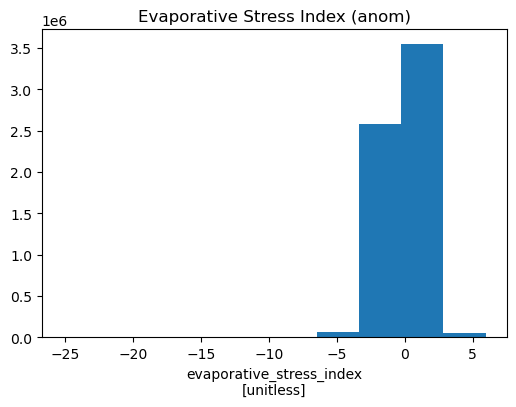

In [57]:
# Plot the subset
plt.figure(figsize=(6,4))
esi.plot();
plt.title('Evaporative Stress Index (anom)');

In [33]:
esi.min().values, esi.max().values
# range is -25 to +5

# how many values are below ~ -5? (determining # of outliers)
outliers = (esi < -5).sum()
outliers

# 862 values below -5 (1 value below -25), keep!

<xarray.DataArray 'esi' ()>
array(862)

### Step 2: Calculate metric
* mean evaporative stress index

In [34]:
esi_mean = esi.mean(dim='time')
esi_mean

<xarray.DataArray 'esi' (lat: 191, lon: 208)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float64 42.02 41.97 41.92 41.87 ... 32.67 32.62 32.57 32.52
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1

In [35]:
esi_mean.min().values, esi_mean.max().values

(array(-4.09898567), array(2.46529722))

### Step 3: Reproject data to census tract projection

In [36]:
df = esi_mean.to_dataframe().reset_index()

In [38]:
unique_esi_entries = df['esi'].nunique()
print(f'There are {unique_esi_entries} unique entries in the esi column.')

There are 17158 unique entries in the esi column.


In [83]:
# Create geometry column from coordinates
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry)

In [84]:
gdf

,lat,lon,esi,geometry
0,42.025,-124.475,NaN,POINT (-124.47500 42.02500)
1,42.025,-124.425,NaN,POINT (-124.42500 42.02500)
2,42.025,-124.375,NaN,POINT (-124.37500 42.02500)
3,42.025,-124.325,NaN,POINT (-124.32500 42.02500)
4,42.025,-124.275,NaN,POINT (-124.27500 42.02500)
...,...,...,...,...
39723,32.525,-114.325,NaN,POINT (-114.32500 32.52500)
39724,32.525,-114.275,NaN,POINT (-114.27500 32.52500)
39725,32.525,-114.225,NaN,POINT (-114.22500 32.52500)
39726,32.525,-114.175,NaN,POINT (-114.17500 32.52500)


<Axes: >

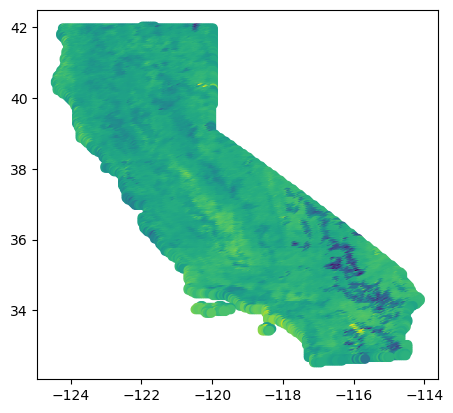

In [85]:
gdf.plot(column='esi') # why is this rotated

In [86]:
# read in CA census tiger file
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
ca_boundaries = ca_boundaries.to_crs("epsg:3310") # CA Albers

In [41]:
# Check the current CRS of the GeoDataFrame
print("gdf CRS:", gdf.crs)
gdf.set_crs(epsg="3310", inplace=True)

# Load your California boundaries GeoDataFrame (ca_boundaries)
# ca_boundaries = gpd.read_file('path_to_ca_boundaries_file')

# Check the current CRS of the California boundaries GeoDataFrame
print("ca_boundaries CRS:", ca_boundaries.crs)

# If they have different CRS, transform one to match the other
if gdf.crs != ca_boundaries.crs:
    gdf = gdf.to_crs(ca_boundaries.crs)

# Now both GeoDataFrames should have the same CRS
print("Transformed gdf CRS:", gdf.crs)

gdf CRS: None
ca_boundaries CRS: epsg:3310
Transformed gdf CRS: EPSG:3310


In [79]:
joined_primary_df

,index,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,index_right,lat,lon,esi
0,2695,06,109,003103,06109003103,31.03,Census Tract 31.03,G5020,S,1458264449,21095995,+38.2247004,-119.7599789,"POLYGON ((-20533.274 -1134.275, -20531.209 -11...",19760,37.275,-124.475,NaN
1,2695,06,109,003103,06109003103,31.03,Census Tract 31.03,G5020,S,1458264449,21095995,+38.2247004,-119.7599789,"POLYGON ((-20533.274 -1134.275, -20531.209 -11...",20176,37.175,-124.475,NaN
2,2695,06,109,003103,06109003103,31.03,Census Tract 31.03,G5020,S,1458264449,21095995,+38.2247004,-119.7599789,"POLYGON ((-20533.274 -1134.275, -20531.209 -11...",20384,37.125,-124.475,NaN
3,2695,06,109,003103,06109003103,31.03,Census Tract 31.03,G5020,S,1458264449,21095995,+38.2247004,-119.7599789,"POLYGON ((-20533.274 -1134.275, -20531.209 -11...",19968,37.225,-124.475,NaN
4,2695,06,109,003103,06109003103,31.03,Census Tract 31.03,G5020,S,1458264449,21095995,+38.2247004,-119.7599789,"POLYGON ((-20533.274 -1134.275, -20531.209 -11...",19969,37.225,-124.425,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39723,2695,06,109,003103,06109003103,31.03,Census Tract 31.03,G5020,S,1458264449,21095995,+38.2247004,-119.7599789,"POLYGON ((-20533.274 -1134.275, -20531.209 -11...",623,41.925,-114.125,NaN
39724,2695,06,109,003103,06109003103,31.03,Census Tract 31.03,G5020,S,1458264449,21095995,+38.2247004,-119.7599789,"POLYGON ((-20533.274 -1134.275, -20531.209 -11...",5615,40.725,-114.125,NaN
39725,2695,06,109,003103,06109003103,31.03,Census Tract 31.03,G5020,S,1458264449,21095995,+38.2247004,-119.7599789,"POLYGON ((-20533.274 -1134.275, -20531.209 -11...",3951,41.125,-114.125,NaN
39726,2695,06,109,003103,06109003103,31.03,Census Tract 31.03,G5020,S,1458264449,21095995,+38.2247004,-119.7599789,"POLYGON ((-20533.274 -1134.275, -20531.209 -11...",2703,41.425,-114.125,NaN


/Users/victoriaford/anaconda3/envs/carb/lib/python3.9/site-packages/geopandas/geodataframe.py:2189: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3310
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


<Axes: >

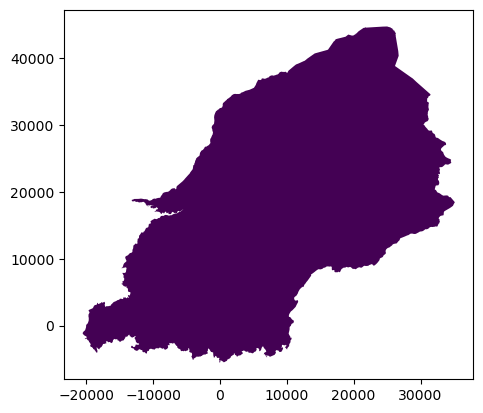

In [87]:
# sjoin with tracts
joined_primary_df = ca_boundaries.sjoin(gdf).reset_index()

# take the mean of the point data within each tract
avg_primary_df = joined_primary_df.groupby('GEOID')['esi'].agg(['mean']).reset_index()

# merge the means with the tract shapefile and transform to geodataframe so we can plot
avg_primary_df = pd.merge(avg_primary_df,ca_boundaries,on="GEOID", how='right')
avg_primary_df = gpd.GeoDataFrame(avg_primary_df,geometry="geometry")
avg_primary_df.plot(column="mean")